In [ ]:
'''

    * Author : Jinhyeok Park (rev.hyeok@gmail.com)
    * Dev. Environment
        - CPU : i7
        - GPU : Radeon Pro 560
        - RAM : 16GB
        - IDE : Pycharm(2017.3.2)
        - Python Ver. : 3.6
        
'''

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
DATASET = 'plco.sas7bdat'

CRC_LABEL = 'confirmed_colo'

DEMOGRAPHICS = [
    'age', 'agelevel', 'arm', 'sex', 'trial_ph_any', 'trial_ph_colo', 'dual',                             # Trial Entry
    'race7', 'hispanic_f', 'educat', 'marital', 'occupat', 'state',                                       # BQ Demographics
    'cig_stat', 'cig_stop', 'cig_years', 'cigpd_f', 'pack_years', 
    'cigar', 'filtered_f', 'pipe', 'rsmoker_f', 'smokea_f', 'smoked_f', 'ssmokea_f',                      # BQ Smoke
    'fh_cancer', 'colo_fh', 'colo_fh_age', 'colo_fh_cnt', 'brothers', 'sisters',                          # BQ Family History
    'bmi_curc', 'bmi_curr', 'height_f', 'weight_f', 'bmi_20', 'weight20_f', 'bmi_50', 'weight50_f',       # BQ Body Type
    'asp', 'asppd', 'ibup', 'ibuppd',                                                                     # BQ NSAIDS
    'arthrit_f', 'bronchit_f', 'colon_comorbidity', 'diabetes_f', 'divertic_f', 'emphys_f',
    'gallblad_f', 'hearta_f', 'hyperten_f', 'liver_comorbidity', 'osteopor_f', 'polyps_f', 'stroke_f',    # BQ Diseases
    # 'hyster_f', 'hystera', 'ovariesr_f', 'tuballig', 'bcontr_f', 'bcontra', 'bcontrt', 'curhorm',
    # 'horm_f', 'horm_stat', 'thorm', 'fchilda', 'livec', 'miscar', 'preg_f', 'prega', 'pregc',
    # 'stillb', 'trypreg', 'tubal', 'fmenstr', 'lmenstr', 'menstrs', 'menstrs_stat_type', 
    # 'post_menopausal', 'bbd', 'benign_ovcyst', 'endometriosis', 'uterine_fib',                            # BQ Female Specific
    # 'enlpros_f', 'enlprosa', 'infpros_f', 'infprosa', 'prosprob_f', 'urinate_f', 'urinatea',              # BQ Male Specific
    # 'surg_age', 'surg_any', 'surg_biopsy', 'surg_prostatectomy', 'surg_resection', 'vasect_f', 'vasecta', # BQ Prostate Surgery
    'colorect_history', 'colscrn_history', 'stool_history'                                                # BQ Screening History
]

NUMERIC_COLS = [
    'age',                                                                             # Trial Entry
    'cig_stop', 'cig_years', 'pack_years', 'smokea_f', 'ssmokea_f',                    # BQ Smoke
    'colo_fh_age', 'colo_fh_cnt',                                                      # BQ Family History
    'bmi_curr', 'height_f', 'weight_f', 'bmi_20', 'weight20_f', 'bmi_50', 'weight50_f' # BQ Body Type
]

CATEGORIZED_COLS = [i for i in DEMOGRAPHICS if i not in NUMERIC_COLS]

In [3]:
'''
    * Function Definition *
        - Dataset Upload
        - Data Pre-processing
'''

# Upload Dataset
def load_data_xls(dataset):
    data_path = os.path.join('./dataset/', dataset)
    dataframe = pd.read_excel(data_path)
    print(dataset, 'has been uploaded')
    return dataframe


def load_data_sas(dataset):
    data_path = os.path.join('./dataset/', dataset)
    dataframe = pd.read_sas(data_path)
    print(dataset, 'has been uploaded')
    return dataframe
    

# View Dataframe information
def get_dataframe_info(dataframe):
    print('\n')
    print(dataframe.info())


# Pre-processing
def drop_categorized_cols(dataframe):
    obj = []
    
    print('Before : ', dataframe.shape)
    for i in range(len(dataframe.columns)):
        if dataframe.iloc[:, i].dtypes == 'object':
            obj.append(dataframe.iloc[:, i].name)

    dataframe = dataframe.drop(columns=obj)
    print('After : ', dataframe.shape)
    return dataframe


def get_demographic_cols(dataframe, demographic_cols):
    return dataframe[demographic_cols]


def get_missing_values(dataframe):
    print(dataframe.isnull().sum())


def processing_categorized_cols(dataframe, categorized_cols, convert_char):
    dataframe[categorized_cols] = dataframe[categorized_cols].fillna(convert_char)
    dataframe[categorized_cols] = dataframe[categorized_cols].astype(str)    
    return dataframe

    
def processing_numeric_cols(dataframe, numeric_cols):
    scaler = MinMaxScaler()
    dataframe[numeric_cols] = dataframe[numeric_cols].fillna(dataframe[numeric_cols].mean())
    dataframe[numeric_cols] = scaler.fit_transform(dataframe[numeric_cols])
    return dataframe

In [4]:
'''
    * Function Definition *
        - Get Operation Time
        - Split Dataset
        - Make Various Dataset
'''

from datetime import datetime
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN


def set_start_time():
    start = datetime.now()
    print('Start Time : {}'.format(start))
    return start


def get_operation_time(start):
    end = datetime.now()
    interval_time = end - start
    print('Operation Time : {}'.format(interval_time))
    print('\n')
    return interval_time


def oversampling_smote(X, y):
    sm = SMOTE()
    X, y = sm.fit_sample(X, y)
    return X, y


def oversampling_adasyn(X, y):
    sm = ADASYN()
    X, y = sm.fit_sample(X, y)
    return X, y


def get_pca_dataset(n, X_train, X_test):
    # Get PCA dataset
    print('PCA begin with n_components : {}'.format(n))
    pca = PCA(n_components=n)
    pca.fit(X_train)

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca


In [5]:
def bulid_model(classifier, parameters, X_train, y_train, X_test, y_test):
    start = set_start_time()

    # Bulid model
    if classifier == 'lr':
        clf = LogisticRegression(C=2, penalty='l2', verbose=3)
        tmp = clf.fit(X_train, y_train)
        print('\n')
        
        # Get Confusion Matrix Values
        pred_cm = tmp.predict(X_test)
        matrix = confusion_matrix(y_test, pred_cm)
        class_name = [0, 1]    
        
        # Get TPR, FPR, ROC, AUC
        pred_df = tmp.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, pred_df)
        roc_auc = auc(fpr, tpr)
    
    elif classifier == 'dt':
        clf = tree.DecisionTreeClassifier()
        tmp = clf.fit(X_train, y_train)
        
        # Get Confusion Matrix Values
        pred_cm = tmp.predict(X_test)
        matrix = confusion_matrix(y_test, pred_cm)
        class_name = [0, 1]    
        
        # Get TPR, FPR, ROC, AUC
        fpr, tpr, thresholds = roc_curve(y_test, pred_cm)
        roc_auc = auc(fpr, tpr)
        
    elif classifier == 'rf':
        clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
        tmp = clf.fit(X_train, y_train)
            
        # Get Confusion Matrix Values
        pred_cm = tmp.predict(X_test)
        matrix = confusion_matrix(y_test, pred_cm)
        class_name = [0, 1]    
        
        # Get TPR, FPR, ROC, AUC
        fpr, tpr, thresholds = roc_curve(y_test, pred_cm)
        roc_auc = auc(fpr, tpr)
        
    elif classifier == 'svm':
        clf = SVC(C=5.0, kernel='linear', gamma=0.005)
        tmp = clf.fit(X_train, y_train)
        
        # Get Confusion Matrix Values
        pred_cm = tmp.predict(X_test)
        matrix = confusion_matrix(y_test, pred_cm)
        class_name = [0, 1]    
        
        pred_df = tmp.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, pred_df)
        roc_auc = auc(fpr, tpr)
    
        
    # Plotting Confusion Matrix
    plt.figure()
    plot_confusion_matrix(matrix, classes=class_name, title='Confusion Matrix')
    plt.show()

    # Get Sensitivity, Specificity, F1-Score
    sensitivity = 100 * (matrix[1, 1] / (matrix[1, 0] + matrix[1, 1]))
    specificity = 100 * (matrix[0, 0] / (matrix[0, 1] + matrix[0, 0]))
    recall = 100 * (matrix[0, 0] / (matrix[0, 0] + matrix[1, 0]))
    f1_score = 2 * sensitivity * recall / (sensitivity + recall)
        
    # Get result
    accuracy = clf.score(X_test, y_test)
    print('Accuracy : {}'.format(accuracy))
    print('Sensitivity : {}'.format(sensitivity))
    print('Specificity : {}'.format(specificity))
    print('F1 Score : {}'.format(f1_score))
    print('AUC : {}'.format(roc_auc))
    
    # Plotting ROC Curve
    plt.title('ROC & AUC')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.05, 1.03])
    plt.ylim([-0.05, 1.03])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # plt.savefig('SMOTE_lr_roc.png')
    plt.show()
    
    # Calculate Operation Time
    get_operation_time(start)

In [6]:
'''
    * Result Visualization *
        - Plotting Confusion Matrix
'''

import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1 #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
               

In [7]:
'''
    * Load Data *
        - Gil Medical Center CRC Dataset
'''

'''Dataset Load & Confirm Information'''

# Load Data
PLCO = load_data_sas(DATASET)

# Show Data Information
get_dataframe_info(PLCO)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


plco.sas7bdat has been uploaded




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154897 entries, 0 to 154896
Columns: 464 entries, dcf_dthc to nrf_days
dtypes: float64(460), object(4)
memory usage: 548.3+ MB
None


In [8]:
'''
    * Column Pre-processing *
        - Drop columns type of 'object'
        - Get columns type of 'BQ'
'''
pp_plco = drop_categorized_cols(PLCO)
# get_dataframe_info(pp_plco)

pp_plco = get_demographic_cols(pp_plco, DEMOGRAPHICS)
print('Get Demographic Columns : ', pp_plco.shape)
# get_dataframe_info(pp_plco)

Before :  (154897, 464)
After :  (154897, 460)


Get Demographic Columns :  (154897, 59)


In [9]:
'''
    * Missing Value Pre-processing *
        - Categorical missing value convert to 'X'
        - Numerical missing value convert to own column's average
    
    
    * Numerical Value Pre-processing * 
        - Scaling using MinMaxScaler (Normalization)
'''

pp_plco = processing_categorized_cols(pp_plco, CATEGORIZED_COLS, 'X')
pp_plco = processing_numeric_cols(pp_plco, NUMERIC_COLS)

'''
    * Apply One-hot Encoding *
        - Using pd.get_dummies()
'''
DF = pd.get_dummies(pp_plco)
# get_dataframe_info(DF)

In [11]:
'''
    * Split Dataset *
        - Split X, y
        - Split Training, Test Set
'''
from sklearn.model_selection import train_test_split

X, y = DF, PLCO[CRC_LABEL]
# print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [15]:
X_train_sm, y_train_sm = oversampling_smote(X_train, y_train)
X_train_ada, y_train_ada = oversampling_adasyn(X_train, y_train)
X_train_pca, X_test_pca = get_pca_dataset(0.85, X_train, X_test)
X_train_pca_sm, X_test_pca_sm = get_pca_dataset(0.85, X_train_sm, X_test)
X_train_pca_ada, X_test_pca_ada = get_pca_dataset(0.85, X_train_ada, X_test)

PCA begin with n_components : 0.85


PCA begin with n_components : 0.85


PCA begin with n_components : 0.85


In [17]:
print(X_train.shape, y_train.shape)
print(X_train.shape, X_test.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print(X_train_sm.shape, y_train_sm.shape)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train_sm == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_sm == 0)))

print(X_train_ada.shape, y_train_ada.shape)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train_ada == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_ada == 0)))

print(X_train_pca.shape, X_test_pca.shape)
print(X_train_pca_sm.shape, X_test_pca_sm.shape)
print(X_train_pca_ada.shape, X_test_pca_ada.shape)

(108427, 255) (108427,)
(108427, 255) (46470, 255)
Before OverSampling, counts of label '1': 1586
Before OverSampling, counts of label '0': 106841 

(213682, 255) (213682,)


Before OverSampling, counts of label '1': 106841


Before OverSampling, counts of label '0': 106841 

(214195, 255) (214195,)
Before OverSampling, counts of label '1': 107354


Before OverSampling, counts of label '0': 106841 

(108427, 49) (46470, 49)
(213682, 45) (46470, 45)
(214195, 45) (46470, 45)


In [ ]:
parameters = {
    'C' : np.linspace(1, 10, 5)
}

Start Time : 2019-03-18 05:54:40.162808


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

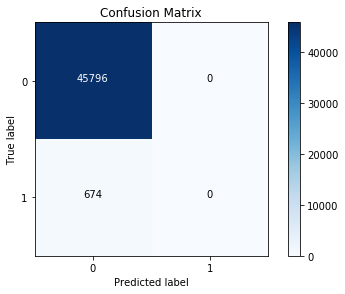

Accuracy : 0.9854960189369486
Sensitivity : 0.0
Specificity : 100.0
F1 Score : 0.0
AUC : 0.6186399340851818


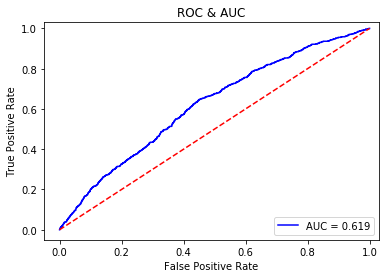

Operation Time : 0:00:28.736900


Start Time : 2019-03-18 05:55:08.899995


[LibLinear]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


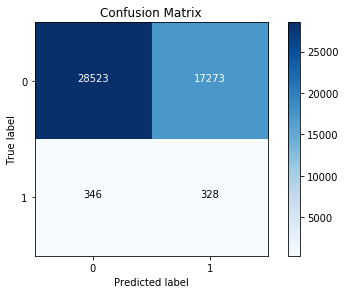

Accuracy : 0.6208521626856036
Sensitivity : 48.6646884272997
Specificity : 62.282732116342046
F1 Score : 65.2101201615667
AUC : 0.5941762306479542


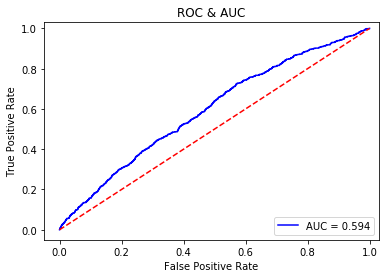

Operation Time : 0:05:56.609550


Start Time : 2019-03-18 06:01:05.509911


[LibLinear]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


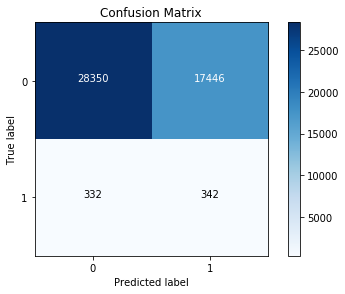

Accuracy : 0.6174306003873467
Sensitivity : 50.74183976261127
Specificity : 61.90496986636388
F1 Score : 67.05848959357812
AUC : 0.5940926772918631


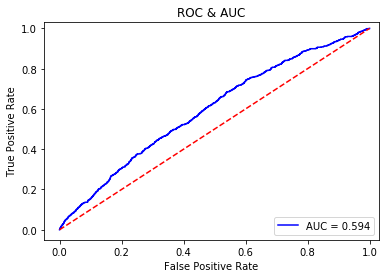

Operation Time : 0:06:54.084197


Start Time : 2019-03-18 06:07:59.594388
[LibLinear]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


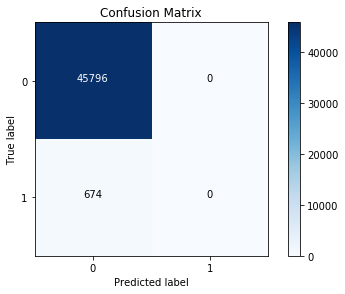

Accuracy : 0.9854960189369486
Sensitivity : 0.0
Specificity : 100.0
F1 Score : 0.0
AUC : 0.6212823454188398


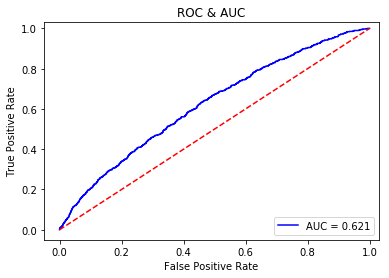

Operation Time : 0:00:00.846474


Start Time : 2019-03-18 06:08:00.441395
[LibLinear]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


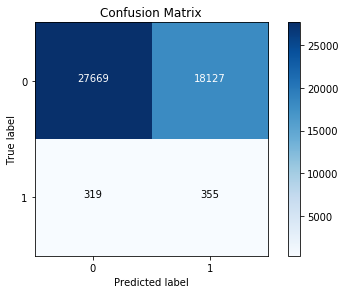

Accuracy : 0.60305573488272
Sensitivity : 52.6706231454006
Specificity : 60.41794043147873
F1 Score : 68.72567181696076
AUC : 0.5979307536739502


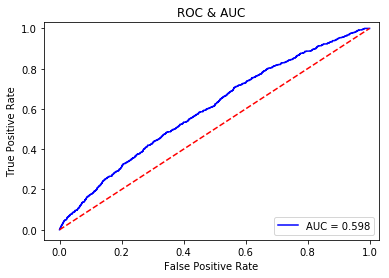

Operation Time : 0:00:00.978734


Start Time : 2019-03-18 06:08:01.420510
[LibLinear]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


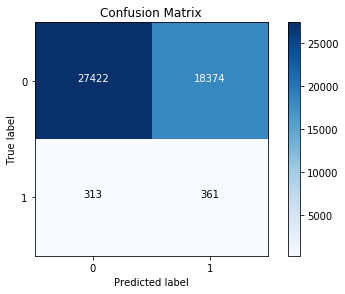

Accuracy : 0.597869593285991
Sensitivity : 53.560830860534125
Specificity : 59.87859201677003
F1 Score : 69.48183425845654
AUC : 0.5974363990168761


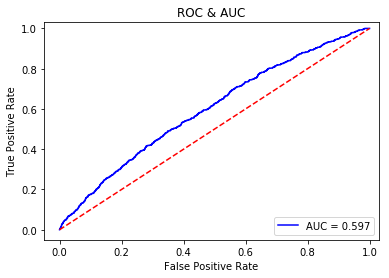

Operation Time : 0:00:00.964207




In [16]:
# bulid_model('lr', parameters, X_train, y_train, X_test, y_test)
# bulid_model('lr', parameters, X_train_sm, y_train_sm, X_test, y_test)
# bulid_model('lr', parameters, X_train_ada, y_train_ada, X_test, y_test)
# bulid_model('lr', parameters, X_train_pca, y_train, X_test_pca, y_test)
# bulid_model('lr', parameters, X_train_pca_sm, y_train_sm, X_test_pca_sm, y_test)
# bulid_model('lr', parameters, X_train_pca_ada, y_train_ada, X_test_pca_ada, y_test)

Start Time : 2019-03-18 04:13:20.970703


Operatin Time : 0:00:14.519580


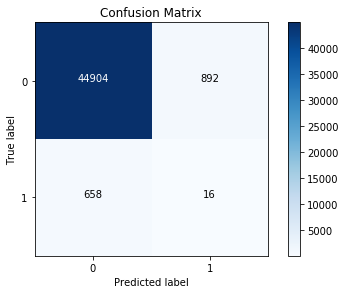

Accuracy : 0.9666451474069292
Sensitivity : 2.3738872403560833
Specificity : 98.05223163595073
F1 Score : 4.636105852794554
AUC : 0.5021305943815341


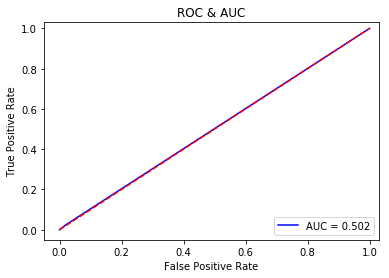

In [96]:
# bulid_model('dt', parameters, X_train, y_train, X_test, y_test)
# bulid_model('dt', parameters, X_train_sm, y_train_sm, X_test, y_test)
# bulid_model('dt', parameters, X_train_ada, y_train_ada, X_test, y_test)
# bulid_model('dt', parameters, X_train_pca, y_train, X_test_pca, y_test)
# bulid_model('dt', parameters, X_train_pca_sm, y_train_sm, X_test_pca_sm, y_test)
# bulid_model('dt', parameters, X_train_pca_ada, y_train_ada, X_test_pca_ada, y_test)

Start Time : 2019-03-18 04:14:56.013006


Operatin Time : 0:00:46.611734


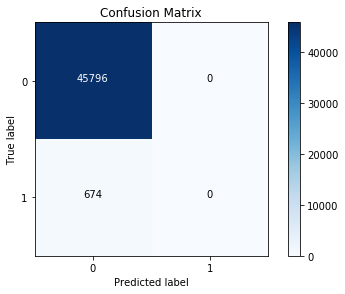

Accuracy : 0.9854960189369486
Sensitivity : 0.0
Specificity : 100.0
F1 Score : 0.0
AUC : 0.5


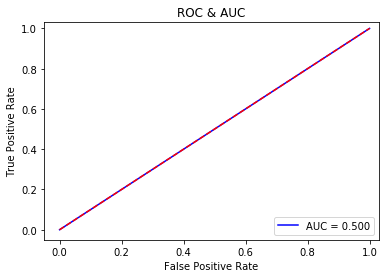

Start Time : 2019-03-18 04:15:46.204295


Operatin Time : 0:02:15.642963


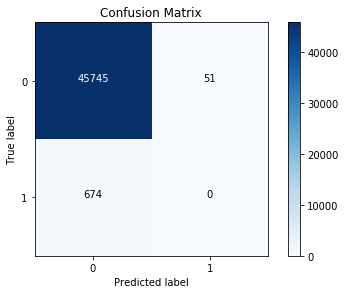

Accuracy : 0.9843985366903378
Sensitivity : 0.0
Specificity : 99.88863656214517
F1 Score : 0.0
AUC : 0.4994431828107258


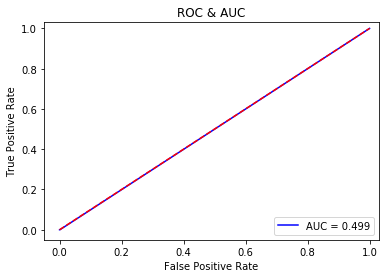

Start Time : 2019-03-18 04:18:05.756029


Operatin Time : 0:02:00.189962


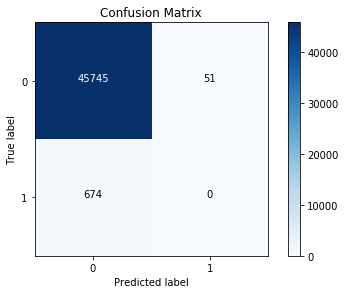

Accuracy : 0.9843985366903378
Sensitivity : 0.0
Specificity : 99.88863656214517
F1 Score : 0.0
AUC : 0.4994431828107258


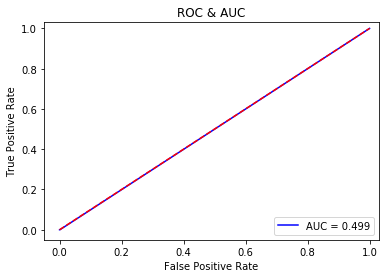

Start Time : 2019-03-18 04:20:09.841619


Operatin Time : 0:01:41.930951


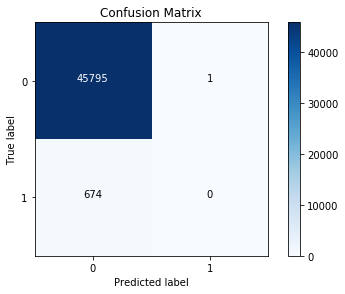

Accuracy : 0.9854744996772111
Sensitivity : 0.0
Specificity : 99.99781640317931
F1 Score : 0.0
AUC : 0.4999890820158966


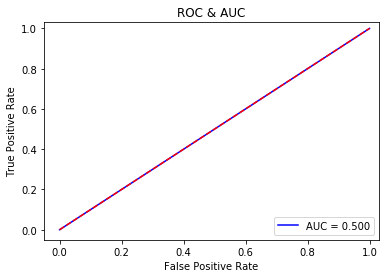

Start Time : 2019-03-18 04:21:53.631363


Operatin Time : 0:02:59.524830


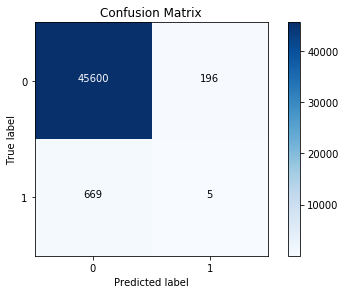

Accuracy : 0.9813858403270928
Sensitivity : 0.741839762611276
Specificity : 99.57201502314612
F1 Score : 1.472594959365583
AUC : 0.501569273928787


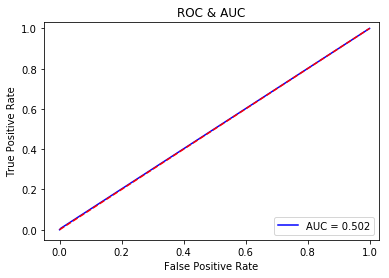

Start Time : 2019-03-18 04:24:55.367294


Operatin Time : 0:02:51.662683


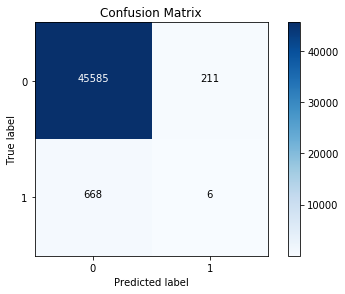

Accuracy : 0.9810845706907683
Sensitivity : 0.8902077151335311
Specificity : 99.53926107083588
F1 Score : 1.7644777362662203
AUC : 0.5021473439298471


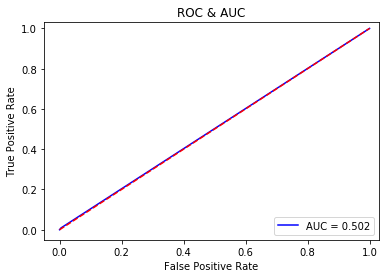

In [100]:
# bulid_model('rf', parameters, X_train, y_train, X_test, y_test)
# bulid_model('rf', parameters, X_train_sm, y_train_sm, X_test, y_test)
# bulid_model('rf', parameters, X_train_ada, y_train_ada, X_test, y_test)
# bulid_model('rf', parameters, X_train_pca, y_train, X_test_pca, y_test)
# bulid_model('rf', parameters, X_train_pca_sm, y_train_sm, X_test_pca_sm, y_test)
# bulid_model('rf', parameters, X_train_pca_ada, y_train_ada, X_test_pca_ada, y_test)

In [ ]:
# bulid_model('svm', parameters, X_train, y_train, X_test, y_test)
# bulid_model('rf', parameters, X_train_sm, y_train_sm, X_test, y_test)
# bulid_model('rf', parameters, X_train_ada, y_train_ada, X_test, y_test)
# bulid_model('rf', parameters, X_train_pca, y_train, X_test_pca, y_test)
# bulid_model('rf', parameters, X_train_pca_sm, y_train_sm, X_test_pca_sm, y_test)
# bulid_model('rf', parameters, X_train_pca_ada, y_train_ada, X_test_pca_ada, y_test)

Start Time : 2019-03-18 15:49:29.092261


In [ ]:
# bulid_model('svm', parameters, X_train_sm, y_train_sm, X_test, y_test)